In [1]:
from fitting import abs_mag_to_L,get_lfpars_shen20,T0,T1,T2,get_lfpars,get_phis
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
from astropy.io import fits
import fitsio
from astropy.cosmology import Planck18
from astropy.cosmology import WMAP9 as cosmo
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.optimize import curve_fit, brentq

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]
# Calculate the fraction of data that remains
fraction_remaining = len(k_gg) / len(k['k_gg'])
print(f"Fraction of data that remained: {fraction_remaining:.2f}")

Fraction of data that remained: 1.00


In [3]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.3) & (d['Z'] < 2.8))[0]
TARGETID = d['TARGETID'][SEL][~indice]
#apr_mag_g = d['APP_MAG_G'][SEL][~indice]
#apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z_desi = d['Z'][SEL][~indice]
d_desi = Planck18.distmod(z_desi).value

In [4]:
TARGETID, indices = np.unique(TARGETID, return_index=True)
#apr_mag_g = apr_mag_g[indices]
#apr_mag_g_err = apr_mag_g_err[indices]
apr_mag_r = apr_mag_r[indices]
apr_mag_r_err = apr_mag_r_err[indices]
d_desi = d_desi[indices]
z_desi = z_desi[indices]
#k_gg = k_gg[indices]
k_rr = k_rr[indices]

In [5]:
# Assuming z_desi is your redshift array
filter_mask = (z_desi > 2.3) & (z_desi < 2.4)

# Apply the filter to all arrays
TARGETID = TARGETID[filter_mask]
#apr_mag_g = apr_mag_g[filter_mask]
#apr_mag_g_err = apr_mag_g_err[filter_mask]
apr_mag_r = apr_mag_r[filter_mask]
apr_mag_r_err = apr_mag_r_err[filter_mask]
d_desi = d_desi[filter_mask]
z_desi = z_desi[filter_mask]
#k_gg = k_gg[filter_mask]
k_rr = k_rr[filter_mask]

# Recalculate N_obs after filtering
N_obs = TARGETID.shape[0]
print(N_obs)

42123


In [6]:
mag_r_bins = np.linspace(np.min(apr_mag_r), np.max(apr_mag_r), 30)
#z_bins = np.linspace(np.min(z_desi), np.max(z_desi), 1)
counts_r,mag_r_edges= np.histogram(apr_mag_r, bins=mag_r_bins)

In [7]:
mag_r_bin_widths = np.diff(mag_r_bins)[0]  # Differences between consecutive bin edges for magnitude
#z_bin_widths = np.diff(z_bins)[0]          # Differences between consecutive bin edges for redshift

In [8]:
def comoving_volume(z1,z2):
    """
    Calculate the comoving volume between two redshifts.
    
    Args:
        z1 (float): Lower redshift bound
        z2 (float): Upper redshift bound
    
    Returns:
        float: Comoving volume in cubic megaparsecs (Mpc^3)
    """
    #d1 = cosmo.comoving_distance(z1).value# Mpc
    #d2 = cosmo.comoving_distance(z2).value# Mpc
    return cosmo.comoving_volume(z2).value-cosmo.comoving_volume(z1).value

In [9]:
# phi from DESI
mag_r_centers = (mag_r_bins[:-1]+mag_r_bins[1:])/2
phi_desi = counts_r/comoving_volume(2.3,2.4)/mag_r_bin_widths
# phi from shen
L = abs_mag_to_L(mag_r_centers - k_rr.mean() - d_desi.mean()-0.7784347252898912)
phi_shen = np.array([0.4*get_phis(x,2.35,"shen20") for x in L])

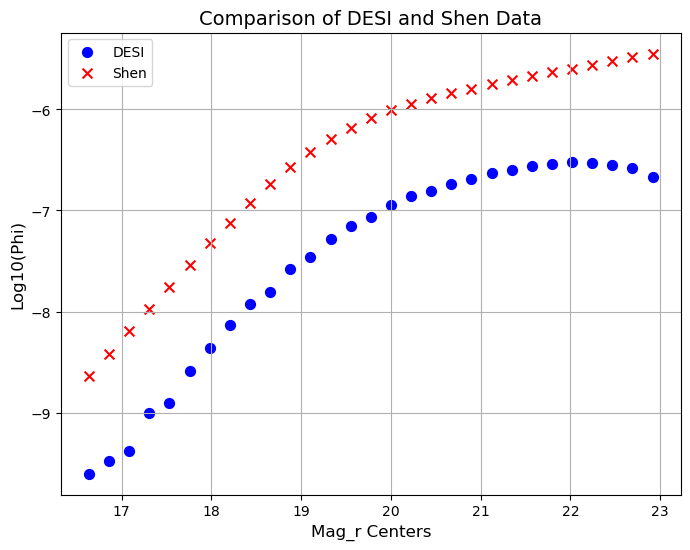

In [10]:
#plt.scatter(mag_r_centers,phi_desi/phi_shen)
# Create the scatter plot with refinements
plt.figure(figsize=(8,6))

# Plot the DESI and Shen data with different colors and markers
plt.scatter(mag_r_centers, np.log10(phi_desi), label='DESI', color='blue', marker='o', s=50)
plt.scatter(mag_r_centers, np.log10(0.16*phi_shen), label='Shen', color='red', marker='x', s=50)

# Add axis labels
plt.xlabel('Mag_r Centers', fontsize=12)
plt.ylabel('Log10(Phi)', fontsize=12)

# Add a title
plt.title('Comparison of DESI and Shen Data', fontsize=14)

# Add a legend
plt.legend()

# Optionally, add gridlines
plt.grid(True)

# Show the plot
plt.show()

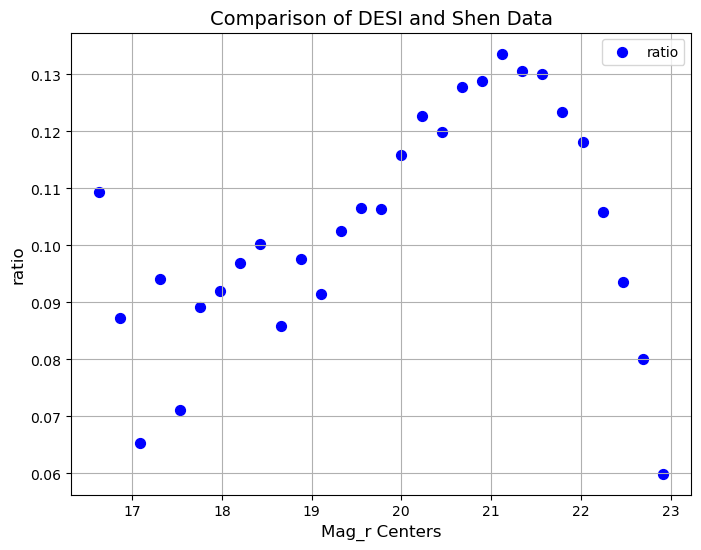

In [11]:
#plt.scatter(mag_r_centers,phi_desi/phi_shen)
# Create the scatter plot with refinements
plt.figure(figsize=(8,6))

# Plot the DESI and Shen data with different colors and markers
plt.scatter(mag_r_centers, phi_desi/phi_shen/0.16, label='ratio', color='blue', marker='o', s=50)

# Add axis labels
plt.xlabel('Mag_r Centers', fontsize=12)
plt.ylabel('ratio', fontsize=12)

# Add a title
plt.title('Comparison of DESI and Shen Data', fontsize=14)

# Add a legend
plt.legend()

# Optionally, add gridlines
plt.grid(True)

# Show the plot
plt.show()

In [12]:
# Fitting
def eff(m, m0, b):
    eff = np.where(m < m0, 1, 10**(-b*(m-m0)/2.5))
    return eff

initial_guess = [19, 1]
phi_ratio = phi_desi/phi_shen/0.16
popt, pcov = curve_fit(eff, mag_r_centers, phi_ratio, p0=initial_guess)
m0_opt, b_opt = popt
print(f"Optimal m0: {m0_opt}, Optimal b: {b_opt}")

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

NameError: name 'popt' is not defined

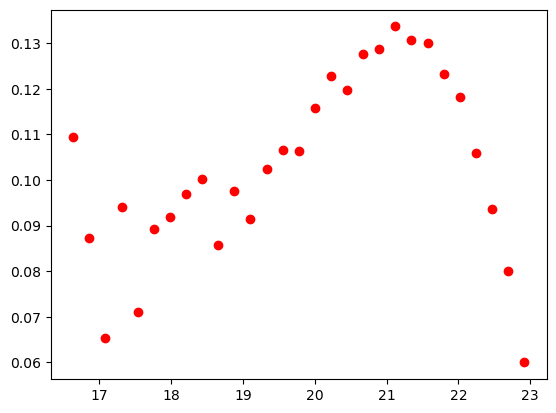

In [13]:
plt.scatter(mag_r_centers, phi_ratio, label='Data', color='red')
plt.plot(mag_r_centers, eff(mag_r_centers, *popt), label='Fitted function', color='blue')
plt.xlabel('mag_r_centers')
plt.ylabel('phi_desi/phi_shen')
plt.legend()
plt.show()

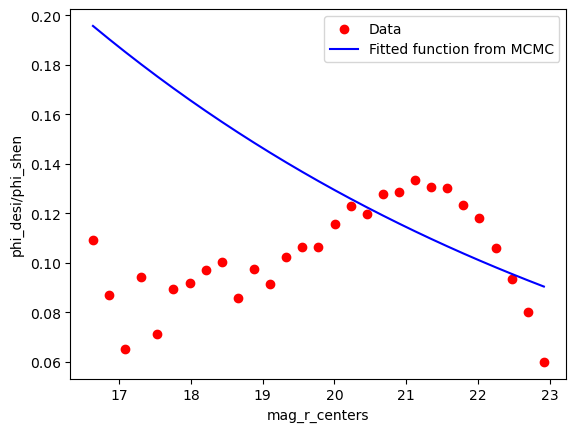

In [14]:
plt.scatter(mag_r_centers, phi_ratio, label='Data', color='red')
plt.plot(mag_r_centers, eff(mag_r_centers,3.370413166999656,0.13350996581073424), label='Fitted function from MCMC', color='blue')
plt.xlabel('mag_r_centers')
plt.ylabel('phi_desi/phi_shen')
plt.legend()
plt.show()

In [15]:
def eff(m, m0, b):
    eff = np.where(m < m0, 1, 10**(-b*(m-m0)/2.5))
    return eff

m = np.linspace(17,23,10)
ratio_pre 

NameError: name 'ratio_pre' is not defined